# Adversarial Training

As we saw before, classifiers can be tricked by a adversary (i.e. the bad guy) using attacks such as FGSM. We would like our classifier to be robust against these kind of attacks because misclassifing a `stop sign` as a `speed limit 100 miles` would not be ideal.

Here comes **Adversarial Training**, where we train our model with our original data *along with generated adversarial examples*. If our model sees more adversarial examples, it can handle them better.


## Learning Goals

1. Understand what is adversarial training
2. Be able to generate adversarial examples from CIFAR10
  - Understand the `CIFAR10 dataset` class from `pytroch`
    - When is getitem called?
  - Understanding Transform in dataset
    - When is transform called?
    - Why do we want transform anyways?
    - ~~Is using transform to generate fake data what make sense~~

----------------------------------------------
3. Why can't I use fgsm transform method to generate the adversarial dataset?
4. How do we build dataset for testing?

## Imports

In [2]:
# Pytorch - Machine Learning Library
import torch
import torch.nn.functional as F
from torch import nn, utils, optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# import tensorflow as tf # the other machine learning library

import requests # this lets us make http requests, so we can use this to download things from the internet
import numpy as np
import matplotlib.pyplot as plt

# libraries to help us process the images
from io import BytesIO
from PIL import Image
from tqdm.notebook import tqdm


### Setting device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Running on {device}')

Running on cuda:0


## Data processing (without adversarial examples)

This is what we do typically.

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:30<00:00, 5502924.52it/s] 


Extracting ./cifar10\cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

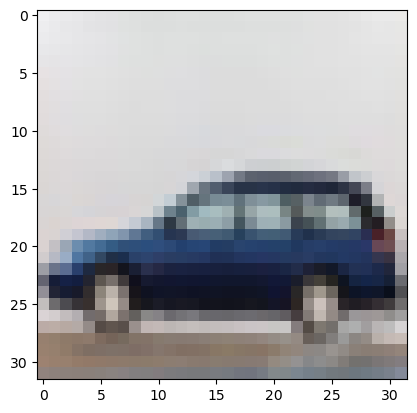

In [6]:
# visualizing a sample from train loader

train_iter = iter(train_loader)

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

So what do we need to change here?

## Data processing (with adversarial examples)

One idea is to generate adversarial examples using the CIFAR10 dataset class. We can then use the adversarial examples to train our model.

***Note:*** this is not the only approach nor the best approach. This is just an introduction to adversarial training.

### The CIFAR10 dataset class

From https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html:
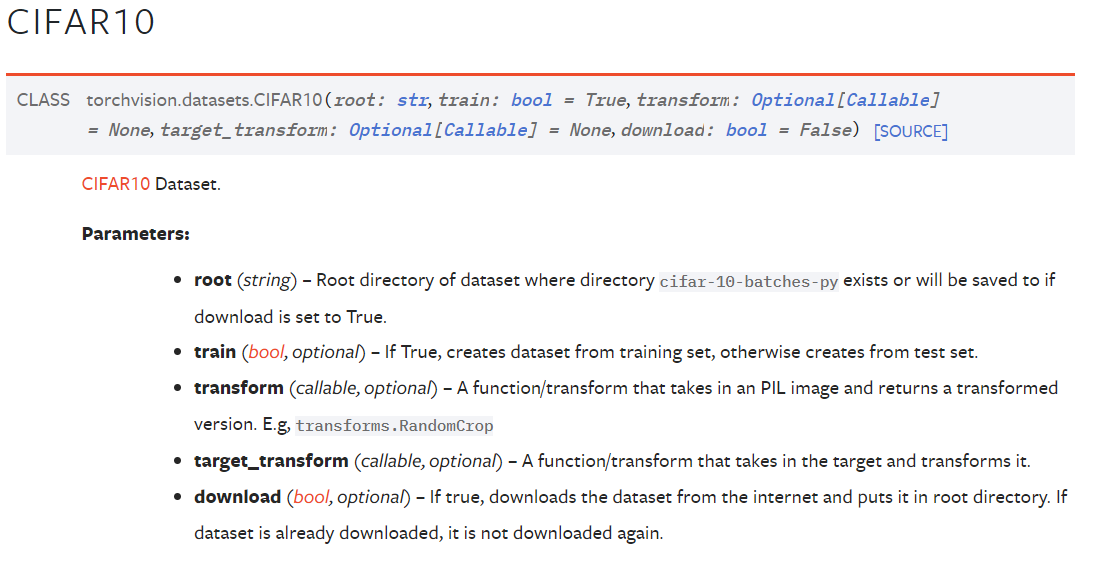

Let's see what we can use from this class. Hmmm, the `transform` argument looks interesting. Let's see if we can use this.

Also, we did some digging we see where `transform` is called so you don't have to dig through the source code.

```python
def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
```
`__getitem__` is called when we do `dataset[index]`. So we can see that `transform` is called when we do `dataset[index]`.

### Making your own transform and using it on CIFAR10

In [69]:
# example transformation class
class RandomAdd:
    def __init__(self, p=0.5):  # this gets called when you do RandomAdd(p=0.5)
        self.p = p
    def __call__(self, sample): # this gets called when you do RandomAdd()(sample)
        image = sample
        if np.random.random() < self.p:
            image = Image.fromarray(np.array(image) + 100)
        return image

How do we use this transform?

In [70]:
randomAddTransform = transforms.Compose([
    RandomAdd(0.5),
    transforms.ToTensor(),
])

trial_train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=randomAddTransform, download=True)
trial_train_loader = torch.utils.data.DataLoader(trial_train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


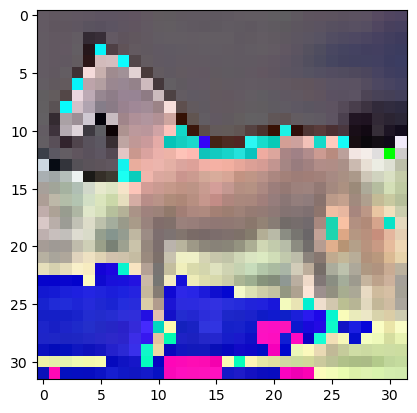

In [87]:
train_iter = iter(trial_train_loader)

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

### Your Turn!

1. If you forgot how to do fgsm, you can click [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for a quick refresher.
2. To run fgsm, you will need a model. You can use the model you trained in the previous notebook, *or* use Jordan's pre-trained model.

#### Defining Jordan's model

In [91]:

class CNNLarge(nn.Module):

    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            # layer 1: 3 x 32 x 32 -> 32 x 32 x 32 (format: channel x width x height)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # layer 2: 32 x 32 x 32 -> 32 x 16 x 16
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # layer 3: 32 x 16 x 16 -> 64 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer 4: 64 x 16 x 16 -> 64 x 8 x 8
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer 5: 64 x 8 x 8 -> 64 x 8 x 8
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer 6: 64 x 8 x 8 -> 128 x 4 x 4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # flatten and output fully-connected layer
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 10))
    
    def forward(self, x):
        x = self.network(x)
        return x

    def size(self):
        parameters = self.parameters()
        size = 0
        for parameter in parameters:
            size += np.prod(parameter.shape)
        return size

#### Defining your own model or use Jordan's pretrained model

In [96]:
# TODO: get your moel 

In [95]:
# TODO: Uncomment to use Jordan's model

# !pip install wget
# # wget: for downloading model weights
# import wget
# model_url = "https://github.com/kuanhenglin/ai-security-workshop/blob/main/cifar10_model.pth?raw=true"
# wget.download(model_url, 'cifar10_model.pth')
# network_load = CNNLarge()
# network_load.load_state_dict(torch.load("cifar10_model.pth"))
# network_load.to(device)
# network_load.eval()

CNNLarge(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), 

In [ ]:
# TODO: define a transformation class that generates a fgsm adversarial example